# Paraphrase Generator with Adversarial Discriminator

# 1. ETL

In [1]:
import pickle
with open("./data/dictionary.pkl", "rb") as file:
    dictionary = pickle.load(file)
len(dictionary.word2idx)
# with open("data/bow_1m_nmt.pkl", "rb") as file:
#     nmt_dataset = pickle.load(file)

31414

In [2]:
import pickle
with open("./data/nmt_trainset.pkl", "rb") as file:
    nmt_trainset = pickle.load(file)
with open("./data/nmt_validset.pkl", "rb") as file:
    nmt_validset = pickle.load(file)

In [3]:
# nmt_trainset = nmt_trainset[:10000]

In [4]:
len(nmt_trainset), len(nmt_validset)

(1000000, 5000)

# 2. EDA & 3. Preprocessing
- Done

# 4. Preparing the dataloader

In [5]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

pad_idx = dictionary.word2idx['<pad>'] ##get the pad index from the vocab

def collate_batch(batch):
    sent_list, synt_lst, trg_list, adv_list = [], [], [], []
    # print(len(batch))
    # sens_, syns_, trgs_ = batch
    # for sen_, syn_, trg_ in zip(sens_, syns_, trgs_):
    for sen_, syn_, trg_, adv_ in batch:
        processed_sent = torch.tensor(sen_, dtype=torch.int64)
        sent_list.append(processed_sent)
        processed_synt = torch.tensor(syn_, dtype=torch.int64)
        synt_lst.append(processed_synt)
        processed_trg = torch.tensor(trg_, dtype=torch.int64)
        trg_list.append(processed_trg)
        adv_ = torch.tensor(adv_, dtype=torch.float32)
        adv_list.append(adv_)

    return pad_sequence(sent_list, padding_value=pad_idx, batch_first=True), pad_sequence(synt_lst, padding_value=pad_idx, batch_first=True), pad_sequence(trg_list, padding_value=pad_idx, batch_first=True), pad_sequence(adv_list, padding_value=pad_idx, batch_first=True)

In [6]:
from torch.utils.data import DataLoader
import random

generator = torch.Generator().manual_seed(6969)
train_dataloader = DataLoader(nmt_trainset, batch_size=16, shuffle=True, collate_fn=collate_batch, generator=generator)
valid_dataloader = DataLoader(nmt_validset, batch_size=16, shuffle=False, collate_fn=collate_batch)

In [7]:
# for sen, syn, trg, adv in train_dataloader:
#     print(sen.shape)
#     print(syn.shape)
#     print(trg.shape)
#     print(adv.shape)
#     print(adv)
#     break

In [8]:
# from torch.utils.data import DataLoader
# import random

# random.seed(6969)
# random.shuffle(nmt_dataset)

# train_range = int(len(nmt_dataset) * 0.7)

# train_set = nmt_dataset[:train_range]
# val_set   = nmt_dataset[train_range:]
# # test_set = train_data[90:]

# train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_batch)
# valid_dataloader = DataLoader(val_set, batch_size=8, shuffle=True, collate_fn=collate_batch)

In [9]:
# for sen, syn, trg, adv in train_dataloader:
#     print(sen.shape)
#     print(syn.shape)
#     print(trg.shape)
#     print(adv.shape)
#     break

In [10]:
import torch #, torchdata, torchtext
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import random, math, time
from torch.autograd import Variable
import operator
import numpy as np

# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# print(device)

#make our work comparable if restarted the kernel
SEED = 6969
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Positional Encoding
$
PE_{pos,2i}     =   sin(\frac{pos}{10000^\frac{2i}{d_{model}}})\\
PE_{pos,2i+1}   =   cos(\frac{pos}{10000^\frac{2i}{d_{model}}})
$

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-np.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding):
        # Residual connection + pos encoding
        token_embedding = token_embedding + self.pos_encoding[:token_embedding.size(0), :]
        return self.dropout(token_embedding)

## Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.sent_layernorm_embedding = nn.LayerNorm(emb_dim, elementwise_affine=False)
        self.adv = nn.Linear(emb_dim, 74)
        
    def forward(self, sent_embeddings):
        # sent_embeddings : batch_size, seq_len, hid_dim
        x = self.sent_layernorm_embedding(sent_embeddings).squeeze(1) # batch_size, hid_dim
        x = self.adv(x) # batch_size, hid_dim
        return x

In [13]:
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, input_token_ids):
        mask = input_token_ids != pad_idx
        mean_mask = mask.float()/mask.float().sum(1, keepdim=True)
        
        x = (x * mean_mask.unsqueeze(2)).sum(1, keepdim=True)

        x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
        return x

## Transformer

In [14]:
class Transformer(nn.Module):
    def __init__(self, input_dim, emb_dim, device, word_dropout = 0.4, dropout = 0.1, max_len = 140):
        super(Transformer, self).__init__()
        
        self.input_dim = input_dim 
        self.emb_dim = emb_dim 

        self.word_dropout = word_dropout
        self.dropout = dropout

        self.scale = np.sqrt(self.emb_dim)
        self.device = device

        self.embedding_encoder = nn.Embedding(input_dim, emb_dim)
        self.embedding_decoder = nn.Embedding(input_dim, emb_dim)
        self.positional_encoder = PositionalEncoding(emb_dim, dropout = 0.0)

        self.transformer = nn.Transformer(d_model = emb_dim, nhead = 12, dropout = dropout)

        self.norm = nn.LayerNorm(emb_dim) 
        self.linear = nn.Linear(emb_dim, input_dim)
        self.adversary = Discriminator(emb_dim)

        self.pooling = MeanPooling()

        self.init_weights() 

    def init_weights(self):
        initrange = 0.1
        # initialize cocabulary matrix weight
        self.embedding_encoder.weight.data.uniform_(-initrange, initrange)
        self.embedding_decoder.weight.data.uniform_(-initrange, initrange)
        # initialize linear weight
        self.linear.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.fill_(0)

    def load_embedding(self, embedding): 
            self.embedding_encoder.weight.data.copy_(torch.from_numpy(embedding)) 
            self.embedding_decoder.weight.data.copy_(torch.from_numpy(embedding)) 

    def generate_square_mask(self, max_sent_len, max_synt_len):
        size = max_sent_len + max_synt_len + 2 #<sos> and <eos>
        mask = torch.zeros((size, size))
        mask[:max_sent_len, max_sent_len:] = float("-inf")
        mask[max_sent_len:, :max_sent_len] = float("-inf")
        return mask
    
    def forward(self, sents, synts, trg):
        #sents : batch_size, sent_len, emb_dim
        #synts : batch_size, synt_len, emb_dim
        #trgs  : batch_size, trg_len, emb_dim 
        batch_size   = sents.size(0)
        max_sent_len = sents.size(1)
        max_synt_len = synts.size(1) - 2  # without <sos> and <eos>
        max_targ_len = trg.size(1)   - 2  # without <sos> and <eos>

        # apply word dropout
        drop_mask = torch.bernoulli(self.word_dropout * torch.ones(max_sent_len)).bool().to(self.device)
        sents = sents.masked_fill(drop_mask, 0)

        # sentence, syntax => embedding
        sent_embeddings = self.embedding_encoder(sents).transpose(0, 1) * self.scale # sent_len, batch_size, emb_dim
        synt_embeddings = self.embedding_encoder(synts).transpose(0, 1) * self.scale # synt_len, batch_size, emb_dim
        synt_embeddings = self.positional_encoder(synt_embeddings) # synt_len, batch_size, emb_dim
        encoder_embeddings = torch.cat((sent_embeddings, synt_embeddings), dim=0) # synt_len + seq_len, batch size, emb_size
        # print(encoder_embeddings.shape)

        # do not allow cross attetion
        src_mask = self.generate_square_mask(max_sent_len, max_synt_len).to(self.device)
        sentence_src_mask = self.generate_square_mask(max_sent_len, -2).to(self.device)
        # target => embedding
        decoder_embeddings = self.embedding_decoder(trg[:, :-1]).transpose(0, 1) * self.scale
        decoder_embeddings = self.positional_encoder(decoder_embeddings) # trg_len, batch_size, emb_dim

        # sequential mask
        trg_mask = self.transformer.generate_square_subsequent_mask(max_targ_len+1).to(self.device)

        # encoder outputs
        memory = self.transformer.encoder(sent_embeddings, mask=sentence_src_mask)
        memory = memory.transpose(0, 1)

        sent_embeds = self.pooling(memory, sents)

        # discriminator
        for p in self.adversary.parameters():
            p.required_grad=False
        adv_outputs = self.adversary(sent_embeds).transpose(0, 1) # batch_size, 74   
        
        # forward
        outputs = self.transformer(encoder_embeddings, decoder_embeddings, src_mask=src_mask, tgt_mask=trg_mask) # trg_len, batch_size, emb_dim
        #decoder outputs # apply linear layer to vocabulary size
        outputs = outputs.transpose(0, 1) # batch_size, trg_len, emb_dim
        outputs = self.linear(outputs.contiguous().view(-1, self.emb_dim)) # batch_size*trg_len, input_dim
        outputs = outputs.view(batch_size, max_targ_len + 1, self.input_dim) # batch_size, trg_len, input_dim
        
        return outputs, adv_outputs
    
    def forward_adv(self, sents):
        batch_size   = sents.size(0)
        max_sent_len = sents.size(1)

        for p in self.adversary.parameters():
            p.required_grad=True

        # do not allow cross attetion
        src_mask = self.generate_square_mask(max_sent_len, -2).to(self.device)

        # encoder outputs
        sent_embeddings = self.embedding_encoder(sents).transpose(0, 1) * self.scale # sent_len, batch_size, emb_dim

        memory = self.transformer.encoder(sent_embeddings, mask=src_mask)
        memory = memory.transpose(0, 1)
        sent_embeds = self.pooling(memory, sents) #batch_size, 74
        adv_outputs = self.adversary(sent_embeds)
        return adv_outputs
    
    def generate(self, sents, synts, max_len = 30, sample=True, temp=0.5):
        #sents  : batch_size, seq_len, emb_dim 
        #synts  : batch_size, seq_len, emb_dim
        batch_size   = sents.size(0)
        max_sent_len = sents.size(1)
        max_synt_len = synts.size(1) - 2  # count without <sos> and <eos>
        max_targ_len = max_len
        
        # output index starts with <sos>
        idxs = torch.zeros((batch_size, max_targ_len+2), dtype=torch.long).to(self.device)
        idxs[:, 0] = 1
        
        # sentence, syntax => embedding
        sent_embeddings = self.embedding_encoder(sents).transpose(0, 1) * self.scale
        synt_embeddings = self.embedding_encoder(synts).transpose(0, 1) * self.scale
        synt_embeddings = self.positional_encoder(synt_embeddings)
        encoder_embeddings = torch.cat((sent_embeddings, synt_embeddings), dim=0)
        
        # do not allow cross attetion
        src_mask = self.generate_square_mask(max_sent_len, max_synt_len).to(self.device)
        
        # starting index => embedding
        decoder_embeddings = self.embedding_decoder(idxs[:, :1]).transpose(0, 1) * self.scale
        decoder_embeddings = self.positional_encoder(decoder_embeddings)
        
        # sequential mask
        trg_mask = self.transformer.generate_square_subsequent_mask(decoder_embeddings.size(0)).to(self.device)
        
        # encode outputs
        memory = self.transformer.encoder(encoder_embeddings, mask=src_mask)
        
        # auto-regressively generate output
        for i in range(1, max_targ_len+2):
            # if i % 5 == 0:
            #     print(f'epoch : {i}')
            # decode
            outputs = self.transformer.decoder(decoder_embeddings, memory, tgt_mask=trg_mask)
            outputs = self.linear(outputs[-1].contiguous().view(-1, self.emb_dim))
            
            # get argmax index or sample index
            if not sample:
                values, idx = torch.max(outputs, 1)
            else:
                probs = F.softmax(outputs/temp, dim=1)
                idx = torch.multinomial(probs, 1).squeeze(1)
            
            # save to output index
            idxs[:, i] = idx
            
            # concatenate index to decoding
            decoder_embeddings = self.embedding_decoder(idxs[:, :i+1]).transpose(0, 1) * self.scale
            decoder_embeddings = self.positional_encoder(decoder_embeddings)
            
            # new sequential mask
            trg_mask = self.transformer.generate_square_subsequent_mask(decoder_embeddings.size(0)).to(self.device)
        
        return idxs[:, 1:]

### Glove Embedding

In [15]:
from gensim.test.utils import datapath

#you have to put this file in some python/gensim directory; just run it and it will inform where to put....
glove_file = 'data/glove.6B.300d.txt'

In [16]:
with open("./data/dictionary.pkl", "rb") as file:
    dictionary = pickle.load(file)

vocab_dict = dictionary.word2idx

In [17]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

from utils import load_embedding

input_dim = len(vocab_dict)
emb_dim = 300  
word_dropout = 0.4 #following SynPG
dropout     = 0.1

embedding = load_embedding(glove_file, dictionary)

model = Transformer(input_dim=input_dim, emb_dim = emb_dim, device=device, word_dropout = word_dropout, dropout = dropout)
model = model.to(device)
model.load_embedding(embedding)

cuda:1
load 22696 of 31414 from pretrained word embeddings



In [18]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    # for item in params:
    #     print(f'{item:>6}')
    print(f'______\n{sum(params):>6} parameters')
    
count_parameters(model)

______
49621464 parameters


## 6. Training

In [19]:
from tqdm.autonotebook import tqdm

def train(model, loader, epoch, para_optimizer, adv_optimizer, para_criterion, adv_criterion, clip, loader_length, accumulation_steps = 1):
    
    model.train()

    for idx, (sents_, synts_, trgs_, adv_targs) in enumerate(tqdm(loader)):

        epoch_loss = 0
        adv_total_loss = 0.0	   

        batch_size   = sents_.size(0)
        max_sent_len = sents_.size(1)
        max_synt_len = synts_.size(1) - 2  # count without <sos> and <eos>
        adv_len = 74
        
        # Put input into device
        sents_ = sents_.to(device)
        synts_ = synts_.to(device)
        trgs_ = trgs_.to(device)
        adv_targs = adv_targs.to(device) #batch_size, 74

        #forward adversarial
        outputs = model.forward_adv(sents_) #batch_size, 74
        #optimize adversarial
        adv_loss = adv_criterion(outputs, adv_targs)
        # print('adv_loss',adv_loss)
        adv_loss.backward()
        adv_total_loss += adv_loss.item()

        # if (idx+1) % accumulation_steps == 0:
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        if epoch > 0:
            adv_optimizer.step()
        adv_optimizer.zero_grad()

        #foward model
        outputs, adv_outputs = model(sents_, synts_, trgs_)
        adv_outputs = adv_outputs.transpose(0,1) #seq_len, batch_size, 74
        
        # calculate loss
        targs_ = trgs_[:, 1:].contiguous().view(-1) #Without <SOS>
        outputs_ = outputs.contiguous().view(-1, outputs.size(-1))
        
        #optimize model
        loss = para_criterion(outputs_, targs_)
        # print('optim loss',loss)
        if epoch > 0: 
            loss -= 1 * adv_criterion(adv_outputs, adv_targs)
        loss.backward()
        epoch_loss += loss.item()
        # print('epoch_loss',epoch_loss)

        # if (idx+1) % accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        para_optimizer.step()
        para_optimizer.zero_grad()

    # return epoch_loss / loader_length, adv_total_loss / loader_length
    return epoch_loss, adv_total_loss

def evaluate(model, loader, para_criterion, adv_criterion, loader_length):

    #turn off dropout (and batch norm if used)
    model.eval()
    para_loss = 0
    adv_loss = 0
    with torch.no_grad():

        for sents_, synts_, trgs_, adv_targs in tqdm(loader):

            batch_size   = sents_.size(0)
            max_sent_len = sents_.size(1)
            max_synt_len = synts_.size(1) - 2  # count without <sos> and <eos>
            
            # Put input into device
            sents_ = sents_.to(device)
            synts_ = synts_.to(device)
            trgs_ = trgs_.to(device)
            adv_targs = adv_targs.to(device)
            
            #forward 
            outputs, adv_outputs = model(sents_, synts_, trgs_)
            
            targs_ = trgs_[:, 1:].contiguous().view(-1) #Without <SOS>
            outputs_ = outputs.contiguous().view(-1, outputs.size(-1))


            adv_outputs = adv_outputs.transpose(0,1)

            para_loss += para_criterion(outputs_, targs_) 
            adv_loss += adv_criterion(adv_outputs, adv_targs)

            # if torch.isnan(adv_criterion(adv_outputs, adv_targs)) != True:
            #     adv_loss += adv_criterion(adv_outputs, adv_targs)


    return para_loss / loader_length, adv_loss / loader_length

/tmp/ipykernel_165431/3737267708.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
import torch.optim as optim

pad_idx = dictionary.word2idx['<pad>'] ##get the pad index from the vocab

# lr = 10e-4 #Following SynPG
fast_lr = 1e-4
lr = 2e-5
wd = 1e-2 #Following SynPG
#training hyperparameters
para_optimizer = optim.Adam(model.parameters(), lr=fast_lr, weight_decay=wd)
adv_optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

para_criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(device)
adv_criterion = nn.BCEWithLogitsLoss().to(device)

In [22]:
train_loader_length = len(list(iter(train_dataloader)))
val_loader_length   = len(list(iter(valid_dataloader)))

train_loader_length, val_loader_length

(62500, 313)

In [23]:
import time
import math
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/adversary_nmt_modify.pt' #Change here

train_losses = []
valid_losses = []
para_losses = []
adv_losses = [] 
for epoch in range(num_epochs):

    start_time = time.time()

    # training 
    train_loss, adv_total_loss = train(model, train_dataloader, epoch, para_optimizer, adv_optimizer, para_criterion, adv_criterion, clip, train_loader_length, accumulation_steps=1)
    para_loss, adv_loss = evaluate(model, valid_dataloader, para_criterion, adv_criterion, val_loader_length)

    valid_loss = para_loss - 0.1 * adv_loss

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(float(valid_loss))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # save model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 313/313 [00:07<00:00, 41.63it/s]


Epoch: 01 | Time: 90m 21s
	Train Loss: 6.034 | Train PPL: 417.245
	 Val. Loss: 6.767 |  Val. PPL: 868.473


  4%|▍         | 2641/62500 [04:16<1:36:47, 10.31it/s]


KeyboardInterrupt: 

## Plot the losses

Text(0, 0.5, 'loss')

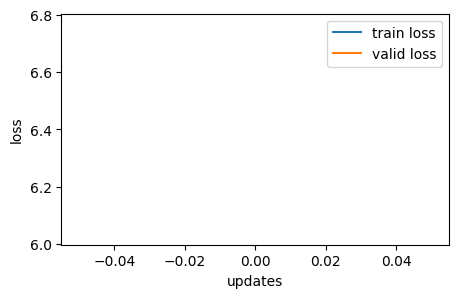

In [24]:
#code here
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [25]:
from utils import synt2str, sent2str, load_embedding, reverse_bpe
    
def generate(model, loader, vocab_transform, device):
    #turn off dropout (and batch norm if used)
    model.eval()
    epoch_loss = 0
    with open("./eval/mrpc_target_sents_adv.txt", "w") as fp1, \
         open("./eval/mrpc_target_synts_adv.txt", "w") as fp2, \
         open("./eval/mrpc_outputs_adv.txt", "w") as fp3:
        with torch.no_grad():
            for sents_, synts_, trgs_, adv_targs in tqdm(loader):

                batch_size   = sents_.size(0)
                max_sent_len = sents_.size(1)
                max_synt_len = synts_.size(1) - 2  # count without <sos> and <eos>
                
                # Put input into device
                sents_ = sents_.to(device)
                synts_ = synts_.to(device)
                trgs_ = trgs_.to(device)
                adv_targs = adv_targs.to(device) #batch_size, 74

                # generate
                idxs = model.generate(sents_, synts_, sents_.size(1), temp=0.5)
                
                # write output
                for sent, idx, targ, synt_ in zip(sents_, idxs.cpu().numpy(), trgs_, synts_):
                    # fp1.write(targ+'\n')
                    # fp2.write(synt_+'\n')
                    # fp3.write(reverse_bpe(synt2str(idx, vocab_transform))+'\n')
                    
                    convert_sent = reverse_bpe(sent2str(sent.detach().cpu().numpy(), vocab_transform).split()) + '\n'
                    convert_synt = synt2str(synt_[1:].tolist(), vocab_transform).replace("<pad>", "") + '\n' 
                    convert_idx = synt2str(idx, vocab_transform)
                    convert_idx = reverse_bpe(convert_idx.split()) + '\n'
                    
                    fp1.write(convert_sent)
                    fp2.write(convert_synt)
                    fp3.write(convert_idx)

## 7. Evaluate

In [26]:
import h5py, os
print("==== loading data ====")
mrpc_set = h5py.File(os.path.join('./test_data/test_data_mrpc.h5'), 'r')
mrpc_set.keys()

==== loading data ====


<KeysViewHDF5 ['sents1', 'sents2', 'synts1', 'synts2']>

In [27]:
mrpc_set['sents1'][0].decode(), mrpc_set['synts2'][0].decode(), mrpc_set['sents2'][0].decode()

("amrozi accused his brother , whom he called `` the witness '' , of deliberately distorting his evidence .",
 "(ROOT (S (VP (VBG referring) (PP (TO to) (NP (PRP him))) (PP (IN as) (NP (NP (RB only) (`` ``) (NP (DT the) (NN witness)) ('' '')) (, ,) (SBAR (IN amrozi) (S (VP (VBN accused) (NP (NP (PRP$ his) (NN brother)) (PP (IN of) (S (ADVP (RB deliberately)) (VP (VBG distorting) (NP (PRP$ his) (NN evidence)))))))))))) (. .)))",
 "referring to him as only `` the witness '' , amrozi accused his brother of deliberately distorting his evidence .")

In [40]:
import h5py, os
print("==== loading data ====")
qq_set = h5py.File(os.path.join('./test_data/test_data_quora.h5'), 'r')
qq_set.keys()

==== loading data ====


<KeysViewHDF5 ['sents1', 'sents2', 'synts1', 'synts2']>

In [41]:
qq_set['sents1'][0].decode(), qq_set['synts2'][0].decode(), qq_set['sents2'][0].decode()

('what minor would complement a computer science major ?',
 '(ROOT (SBARQ (WHNP (WP what)) (SQ (VBZ is) (NP (NP (DT a) (JJ good) (JJ minor)) (SBAR (WHNP (WDT that)) (S (VP (MD will) (VP (VB compliment) (NP (DT a) (NN computer) (NN science)) (ADVP (JJ major)))))))) (. ?)))',
 'what is a good minor that will compliment a computer science major ?')

In [28]:
def is_paren(tok):
    return tok == ")" or tok == "("

def getleaf(tree):
    nonleaves = ''
    for w in str(tree).replace('\n', '').split():
        w = w.replace('(', '( ').replace(')', ' )')
        nonleaves += w + ' '
    
    leaves = []
    arr = nonleaves.split()
    for n, i in enumerate(arr):
        if n + 1 < len(arr):
            tok1 = arr[n]
            tok2 = arr[n + 1]
            if not is_paren(tok1) and not is_paren(tok2):
                leaves.append(arr[n])

    return leaves

def deleaf(tree):
    nonleaves = ''
    for w in str(tree).replace('\n', '').split():
        w = w.replace('(', '( ').replace(')', ' )')
        nonleaves += w + ' '

    arr = nonleaves.split()
    for n, i in enumerate(arr):
        if n + 1 < len(arr):
            tok1 = arr[n]
            tok2 = arr[n + 1]
            if not is_paren(tok1) and not is_paren(tok2):
                arr[n + 1] = ""

    nonleaves = " ".join(arr)
    return nonleaves.split()

In [29]:
#Tokenizer BPE
from subwordnmt.apply_bpe import BPE, read_vocabulary
import codecs
import numpy as np

# load bpe codes
bpe_codes = codecs.open('./data/bpe.codes', encoding='utf-8')
bpe_vocab = codecs.open('./data/vocab.txt', encoding='utf-8')
bpe_vocab = read_vocabulary(bpe_vocab, 50)
bpe = BPE(bpe_codes, '@@', bpe_vocab, None)

import pickle
with open("./data/dictionary.pkl", "rb") as file:
    dictionary = pickle.load(file)

def bpe_tokenizer(sent_, target = False):
 # bpe segment and convert to tensor
    sent_ = bpe.segment(sent_).split()
    sent_ = [dictionary.word2idx[w] if w in dictionary.word2idx else dictionary.word2idx["<unk>"] for w in sent_]
    if target:
        sent_ = [dictionary.word2idx["<sos>"]] + sent_ + [dictionary.word2idx["<eos>"]]
    return sent_

#syntax to syntatic tokenzier
from nltk import ParentedTree
def parser_tokenizer(synt_):
    synt_  = ParentedTree.fromstring(synt_)
    synt_ = deleaf(synt_)
    synt_ = [dictionary.word2idx[f"<{w}>"] for w in synt_ if f"<{w}>" in dictionary.word2idx]
    synt_ = [dictionary.word2idx["<sos>"]] + synt_ + [dictionary.word2idx["<eos>"]]
    return synt_

import pickle
with open('synt_vocab.pkl', 'rb') as f:
    synt_vocab = pickle.load(f)

def bow(synt_):
    synt_bow = np.ones(74)
    synt_ = ['<sos>'] + deleaf(synt_) + ['<eos>']
    for tag in synt_:
        if tag != '<sos>' and tag != '<eos>':
            synt_bow[synt_vocab[tag]-3] += 1
    synt_bow /= synt_bow.sum()
    return synt_bow 

In [30]:
from tqdm import tqdm

def prepare_paraphrase_dataset(sent1, synt2, sent2):
    lists_ = list()
    for sen1, syn2, sen2 in tqdm(zip(sent1,synt2,sent2)):
        sent_ = bpe_tokenizer(sen1.decode())
        syn_  = parser_tokenizer(syn2.decode())
        trg_  = bpe_tokenizer(sen2.decode(), target = True)
        bow_  = bow(syn2.decode())
        lists_.append((sent_, syn_, trg_, bow_))
    return lists_

In [31]:
mrpc_dataset = prepare_paraphrase_dataset(mrpc_set['sents1'], mrpc_set['synts2'], mrpc_set['sents2'])

1920it [00:01, 1118.74it/s]


In [32]:
from torch.utils.data import DataLoader
import random

random.seed(6969)
random.shuffle(mrpc_dataset)

test_dataloader = DataLoader(mrpc_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)

In [33]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)

from utils import load_embedding

input_dim   = len(vocab_dict)
emb_dim     = 300  
word_dropout = 0.4
dropout      = 0.1

embedding = load_embedding(glove_file, dictionary)

model = Transformer(input_dim=input_dim, emb_dim = emb_dim, device=device, word_dropout = word_dropout, dropout = dropout)
model = model.to(device)
model.load_embedding(embedding)

save_path = f'models/adversary_nmt_modify.pt' #Change here
model.load_state_dict(torch.load(save_path, map_location=device))

cuda:1
load 22696 of 31414 from pretrained word embeddings



<All keys matched successfully>

In [34]:
generate(model, test_dataloader, dictionary, device)

100%|██████████| 120/120 [00:20<00:00,  5.85it/s]


## 8. Metric

In [35]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

def cal_bleu(hypothesis, reference, n):
    hypothesis = hypothesis.strip().split(' ')
    reference = reference.strip().split(' ')

    if n == 0:
        return sentence_bleu([reference], hypothesis)
    elif n == 1:
        weights = (1, 0, 0, 0)
    elif n == 2:
        weights = (0, 1, 0, 0)
    elif n == 3:
        weights = (0, 0, 1, 0)
    elif n == 4:
        weights = (0, 0, 0, 1)

    return sentence_bleu([reference], hypothesis, weights=weights)     

In [36]:
with open('./eval/target_sents_adv.txt') as fp:
    targs = fp.readlines()
with open('./eval/outputs_adv.txt') as fp: 
    preds = fp.readlines()

print(f"number of examples: {len(preds)}")

number of examples: 160


In [37]:
targs[0], preds[0]

('the face of president saddam hussein was added to iraqi currency after the 1991 gulf war .\n',
 'the the a the the be this the the meaningof you .\n')

In [39]:
scores = [cal_bleu(pred, targ, 1) for pred, targ in zip(preds, targs)]

print(f"BLEU: {np.mean(scores)*100.0}")

BLEU: 9.747954332029078
